In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

## **步驟**

1. 資料清理（anomaly_train.csv 刪除日期不在範圍內的資料）
2. 按照oven_id將資料分成10個csv檔
3. 敘述統計
4. 將anomaly_train分爐後的資料跟cooler.csv、power.csv做結合

In [ ]:
## 獲取當前工作路徑
current_directory = os.getcwd()

### **1. 資料清理**

    1-1. 先把資料按照產線分兩組  
    1-2. 資料清洗，方法有兩種，如下：
        - 方法一：刪除日期不在範圍內的資料
        - 方法二：按照月份推測正確的年份（最終選擇方法一，所以底下沒有方法二的code）

In [ ]:
anomaly_train_relative_path = os.path.join(current_directory, 'data/row_data', 'anomaly_train.csv')
anomaly_train = pd.read_csv(anomaly_train_relative_path)

## 1-1 分組
filter = anomaly_train["oven_id"].str.startswith("1")

df_p1 = anomaly_train[filter]
df_p2 = anomaly_train[-filter]

df_p1["date"] = pd.to_datetime(df_p1["date"])
df_p2["date"] = pd.to_datetime(df_p2["date"])

## 1-2 刪資料
# 產線一日期範圍
start_date = pd.to_datetime("2021/12/27")
end_date = pd.to_datetime("2022/9/1")

# 删除不在日期範圍內的row
df_p1_dataDelete = df_p1[(df_p1["date"] >= start_date) & (df_p1["date"] <= end_date)]

# 產線二日期範圍
start_date = pd.to_datetime("2021/12/27")
end_date = pd.to_datetime("2023/2/6")

# 删除不在日期範圍內的row
df_p2_dataDelete = df_p2[(df_p2["date"] >= start_date) & (df_p2["date"] <= end_date)]

C:\Users\cherr\AppData\Local\Temp\ipykernel_2496\2002197080.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p1["date"] = pd.to_datetime(df_p1["date"])
C:\Users\cherr\AppData\Local\Temp\ipykernel_2496\2002197080.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p2["date"] = pd.to_datetime(df_p2["date"])


### **3. 按照oven_id將資料分成10個csv檔**

In [ ]:
def devide(df, column_name, output_filepath):
    grouped = df.groupby(column_name)

    for group_name, group_data in grouped:
        # 文件名
        csv_filename = f"{group_name}.csv"
        output_path = os.path.join(current_directory, output_filepath, csv_filename)

        # 輸出
        group_data.to_csv(output_path, index=False)
        print(f"{csv_filename} 已創建")

In [ ]:
devide(df_p1_dataDelete, "oven_id", r"data/anomaly_divided_data")
devide(df_p2_dataDelete, "oven_id", r"data/anomaly_divided_data")

1B0.csv 已創建
1C0.csv 已創建
1D0.csv 已創建
1E0.csv 已創建
1G0.csv 已創建
2B0.csv 已創建
2C0.csv 已創建
2D0.csv 已創建
2E0.csv 已創建
2G0.csv 已創建


### **3. 做敘述統計**

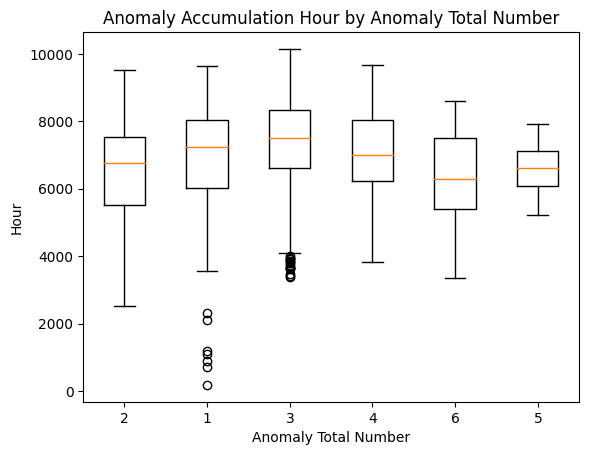

In [ ]:
anomaly_train_relative_path = os.path.join(current_directory, 'data/row_data', 'anomaly_train.csv')
anomaly_train = pd.read_csv(anomaly_train_relative_path)

groups = anomaly_train.groupby('anomaly_total_number')
data_to_plot = [group['anomaly_accumulation_hour'] for name, group in groups]


plt.boxplot(data_to_plot, labels=anomaly_train['anomaly_total_number'].unique())
plt.title("Anomaly Accumulation Hour by Anomaly Total Number")
plt.xlabel("Anomaly Total Number")
plt.ylabel("Hour")
plt.show()

In [ ]:
def box_plot(oven_id):
    input_path = os.path.join(current_directory, 'data/anomaly_divided_data', f'{oven_id}.csv')
    df = pd.read_csv(input_path)

    groups = df.groupby('anomaly_total_number')
    data_to_plot = [group['anomaly_accumulation_hour'] for name, group in groups]
    plt.figure(figsize=(3, 3))
    plt.boxplot(data_to_plot, labels=df['anomaly_total_number'].unique())
    plt.title(f"{oven_id} - Accumulation Hour by Anomaly Total Number")
    plt.xlabel("Anomaly Total Number")
    plt.ylabel("Hour")

    plt.ylim(0, 10000)

    plt.show()

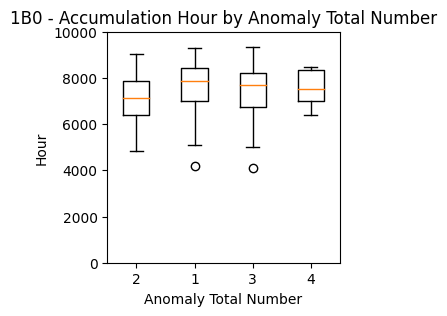

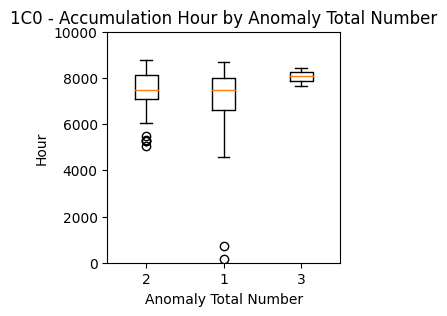

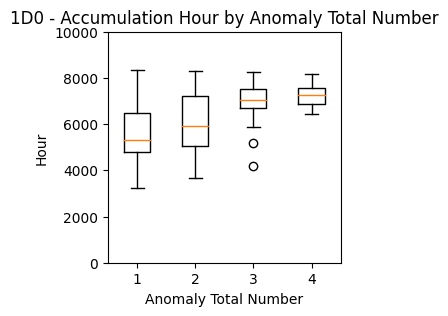

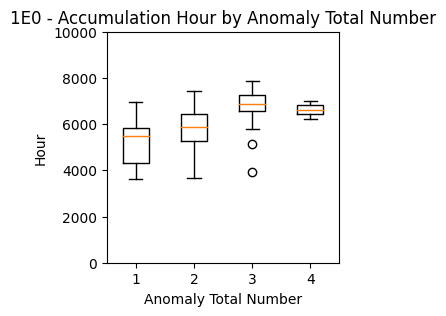

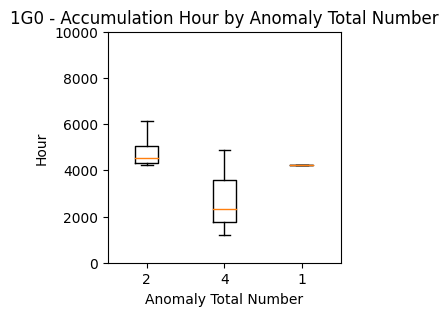

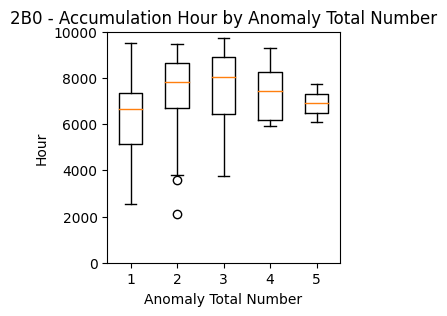

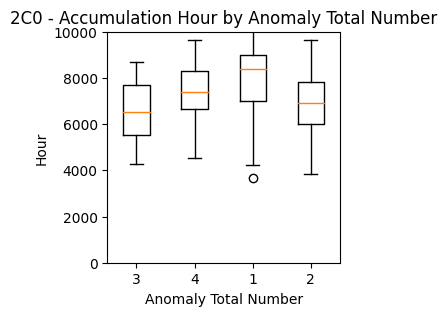

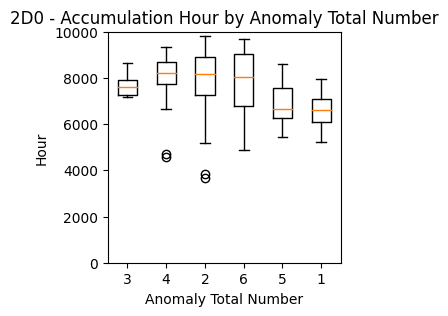

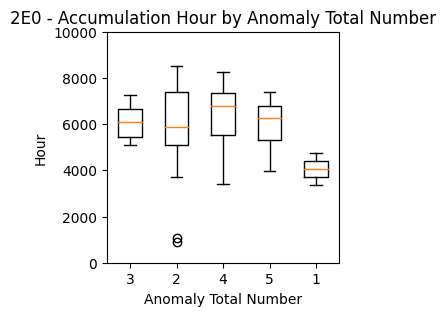

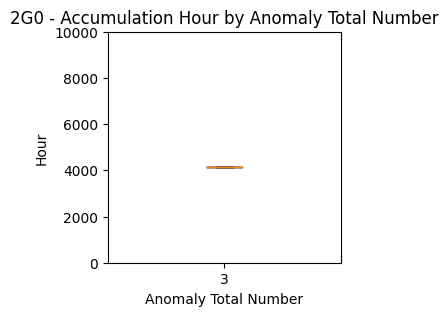

In [ ]:
for group_name in sorted(list(set(anomaly_train["oven_id"]))):
    box_plot(group_name)

In [ ]:
def plot(oven_id):
    input_path = os.path.join(current_directory, 'data/anomaly_divided_data', f'{oven_id}.csv')
    df = pd.read_csv(input_path)

    # 計算每個 layer_id 對應的累積故障數量
    cumulative_counts = df.groupby('layer_id')['anomaly_total_number'].sum()

    # 畫圖
    plt.figure(figsize=(4, 4))
    plt.bar(df['layer_id'].unique(), cumulative_counts, align='center', alpha=0.7)
    plt.xlabel("Layer ID")
    plt.ylabel("Cumulative Anomaly Count")
    plt.title(f"{group_name} - Cumulative Anomaly Count by Layer ID")
    plt.xticks(df['layer_id'].unique())
    plt.show()

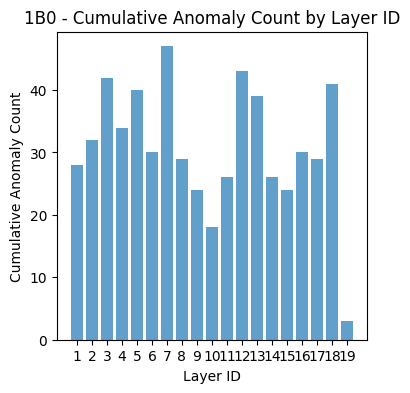

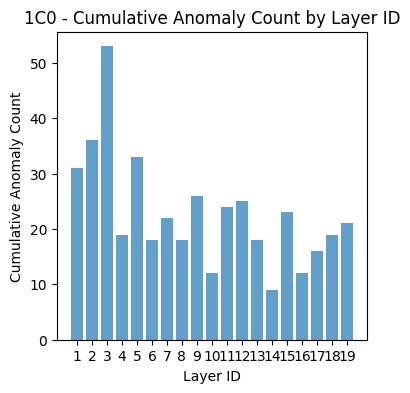

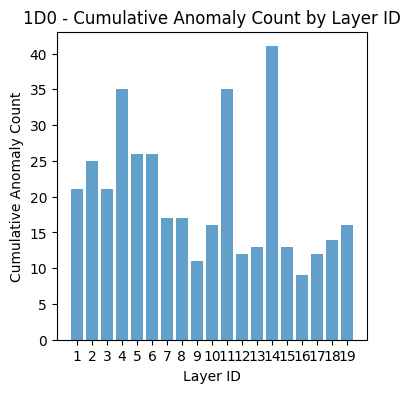

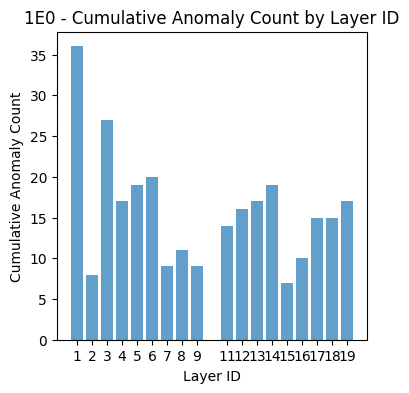

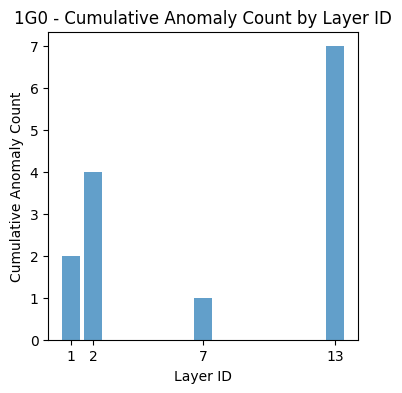

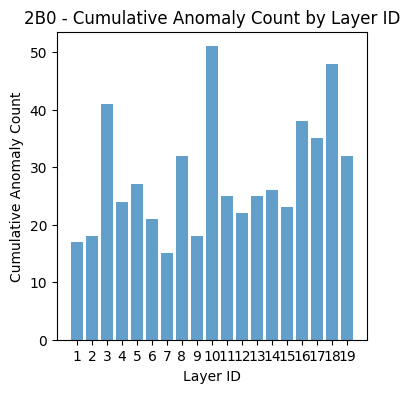

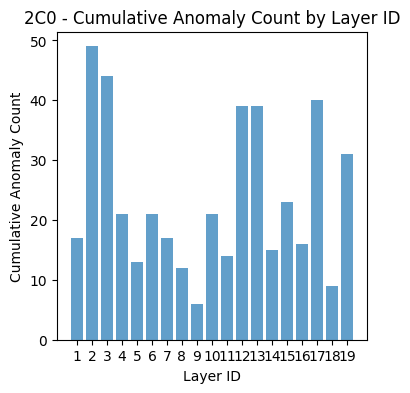

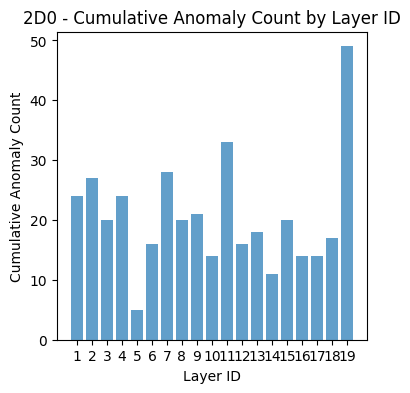

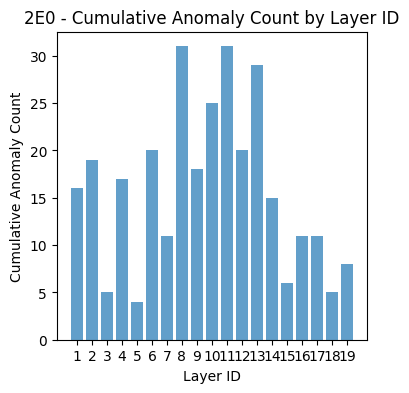

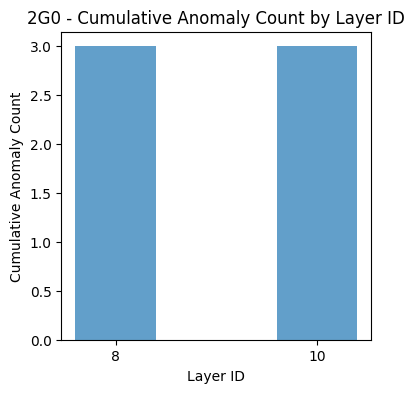

In [ ]:
for group_name in sorted(list(set(anomaly_train["oven_id"]))):
    plot(group_name)

每個爐的分布都不太相同，因此決定一個爐一個模型

### **4. 結合cooler.csv、power.csv 資料**


In [ ]:
oven_id_lst = ['1B0', '1C0', '1D0', '1E0', '1G0', '2B0', '2C0', '2D0', '2E0', '2G0']

In [ ]:
cooler_relative_path = os.path.join(current_directory, 'data/row_data', 'cooler.csv')
cooler = pd.read_csv(cooler_relative_path)
# '/content/drive/data/cooler.csv'

# 將 cooler_id 中以 "temperature" 結尾的行選擇出來，形成 temperature_df
temperature_df = cooler[cooler['cooler_id'].str.endswith('temperature')]

# 將 cooler_id 中以 "water_volume" 結尾的行選擇出來，形成 water_volume_df
water_volume_df = cooler[cooler['cooler_id'].str.endswith('water_volume')]

# 重新設定索引
temperature_df.reset_index(drop=True, inplace=True)
water_volume_df.reset_index(drop=True, inplace=True)

water_volume_df = water_volume_df.set_index('cooler_id')
temperature_df = temperature_df.set_index('cooler_id')

In [ ]:
power_relative_path = os.path.join(current_directory, 'data/row_data', 'power.csv')
power = pd.read_csv(power_relative_path)

bins = [0]
for index, row in power.iterrows():
    bins.append(row["accumulation_hour"].split('-')[1])

label_1 = list(power["power_setup(other_lamp)"])
label_2 = list(power["power_setup(lamp_1_2_60_61_62_63_121_122)"])

spe_lamp = [1, 2, 60, 61, 62, 63, 121, 122]
spe_lamp = [str(i) for i in spe_lamp]

In [ ]:
def combine_data(oven_id):
    input_file_path = os.path.join(current_directory, "data/anomaly_divided_data", f"{oven_id}.csv")
    df = pd.read_csv(input_file_path)

    if oven_id == '1E0' or oven_id == '2E0':
        df['oven_id'] = oven_id

    water_volumn = []
    temp_a = []
    temp_b = []
    for index, row in df.iterrows():
        id = int(row['layer_id'])
        volumn = (water_volume_df.loc[f'Slot{id}_water_volume'][oven_id] + water_volume_df.loc[f'Slot{id+1}_water_volume'][oven_id])/2
        water_volumn.append(volumn)
        a_temp = 0
        b_temp = 0
        if id == 19:
            a_temp = temperature_df.loc[f'S{id:02d}_A_temperature'][oven_id]
            b_temp = temperature_df.loc[f'S{id:02d}_B_temperature'][oven_id]

        else:
            a_temp = (temperature_df.loc[f'S{id:02d}_A_temperature'][oven_id] + temperature_df.loc[f'S{id+1:02d}_A_temperature'][oven_id])/2
            b_temp = (temperature_df.loc[f'S{id:02d}_B_temperature'][oven_id] + temperature_df.loc[f'S{id+1:02d}_B_temperature'][oven_id])/2
        temp_a.append(a_temp)
        temp_b.append(b_temp)
    dic = pd.DataFrame({
        'water_volumn': water_volumn,
        'Temperature_A': temp_a,
        'Temperature_B': temp_b
    })

    df = pd.concat([df, dic], axis=1)

    ## power ##
    has_special_or_not = []
    for index, row in df.iterrows():
        has_special_or_not.append(0)
        for i in spe_lamp:
            if i in row["lamp_id"].split('_'):
                has_special_or_not[index] += 1
                break
        has_special_or_not[index] /= int(row["anomaly_total_number"])

    has_special_or_not = pd.DataFrame({'lamp_special_rartio':has_special_or_not})
    df = pd.concat([df, has_special_or_not], axis = 1)

    df["power(other)"] = pd.cut(df["anomaly_accumulation_hour"].values, bins=bins, labels=label_1)
    df["power(lamp_1_2_60_61_62_63_121_122)"] = pd.cut(df["anomaly_accumulation_hour"].values, bins=bins, labels=label_2)

    power_count = []
    for index, row in df.iterrows():
        temp = (1-row["lamp_special_rartio"])*row["power(other)"] + row["lamp_special_rartio"]*row["power(lamp_1_2_60_61_62_63_121_122)"]
        power_count.append(temp)

    power_count = pd.DataFrame({'power_count': power_count})
    df = pd.concat([df, power_count], axis=1)

    column_to_move = 'anomaly_total_number'
    df[column_to_move] = df.pop(column_to_move)

    output_path = os.path.join(current_directory, 'data/anomaly_with_power_cooler', f'{oven_id}.csv')
    df.to_csv(output_path)
    print(oven_id, 'finished')

In [ ]:
for id in oven_id_lst:
    combine_data(id)

1B0 finished
1C0 finished
1D0 finished
1E0 finished
1G0 finished
2B0 finished
2C0 finished
2D0 finished
2E0 finished
2G0 finished
